In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
graph_builder

In [2]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")
ls_api_key      = os.getenv("LANGSMITH_API_KEY")
ls_endpoint     = os.getenv("LANGSMITH_ENDPOINT")
ls_project      = os.getenv("LANGSMITH_PROJECT")
ls_tracing_flag = os.getenv("LANGSMITH_TRACING", "false").lower() == "true"

llm = init_chat_model("openai:gpt-4.1-mini",openai_api_key=api_key)

# if ls_tracing_flag:
#     from langchain.callbacks.tracers import LangsmithTracer
#     tracer = LangsmithTracer(
#         project_name=ls_project,
#         api_key=ls_api_key,
#         endpoint=ls_endpoint,
#     )
#     tracer.init()

In [3]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [23]:
graph_builder.add_edge(START, "chatbot")

In [24]:
graph = graph_builder.compile()

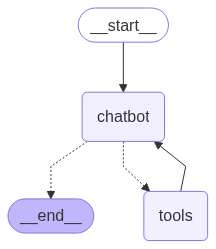

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Widget Interface Chat

In [26]:
import threading
import ipywidgets as widgets
from IPython.display import display, clear_output

# ─── YOUR STREAMING FUNCTION ──────────────────────────────────────────────────
def stream_graph_updates(user_input: str, out_widget):
    for event in graph.stream({"messages":[{"role":"user","content":user_input}]}):
        for value in event.values():
            msg = value["messages"][-1].content
            out_widget.append_stdout(f"Assistant: {msg}\n")

input_box = widgets.Text(
    placeholder="Type something…",
    layout=widgets.Layout(width="70%")
)
send_button = widgets.Button(description="Send")
output_area = widgets.Output(layout=widgets.Layout(border="1px solid lightgray"))

ui = widgets.HBox([input_box, send_button])
display(ui, output_area)

def on_send_click(_):
    user_text = input_box.value.strip()
    if not user_text:
        return
    
    input_box.value = ""
    with output_area:
        output_area.append_stdout(f"You: {user_text}\n")
    
    if user_text.lower() in ("quit", "exit", "q"):
        with output_area:
            output_area.append_stdout("Goodbye!\n")
        input_box.disabled = True
        send_button.disabled = True
        return

    threading.Thread(
        target=stream_graph_updates,
        args=(user_text, output_area),
        daemon=True
    ).start()

send_button.on_click(on_send_click)

Output(layout=Layout(border_bottom='1px solid lightgray', border_left='1px solid lightgray', border_right='1px…

### Command Line Interface Chat

In [27]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  My name fadly


Assistant: Hello Fadly! How can I assist you today?


User:  no, thankyou


Assistant: You're welcome! If you need anything else, feel free to ask. Have a great day!


User:  q


Goodbye!


### Add tool (e.g: Travily)

In [5]:
from langchain_tavily import TavilySearch

travily_api_key = os.getenv("TRAVILY_API_KEY")
tool = TavilySearch(max_results=2, tavily_api_key=travily_api_key)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki',
   'url': 'https://deepwiki.com/langchain-ai/langgraph-101/2.2-nodes-and-edges',
   'content': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki Nodes and Edges Nodes and Edges What are Nodes and Edges? In LangGraph, a graph is composed of nodes connected by edges to form a directed workflow. Nodes are the workhorses of LangGraph - they are Python functions that receive the current graph state as input, perform operations, and return updates to that state. Edges define the flow of execution between nodes in a LangGraph. graph_builder.add_edge("retrieve_documents", "generate_response") Conditional edges use a function to determine the next node based on the current state. Building a Graph with Nodes and Edges graph_builder.add_node("retrieve_documents", retrieve_documents) graph_builder.add_edge(

### Initialize Chatbot with Tools

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

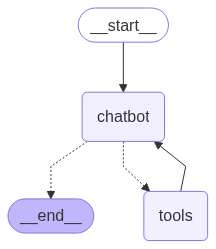

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Command Line Interface Chat with Tool (Tavily)

In [31]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  q


Goodbye!


### Add memory checkpoint

In [12]:
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(State)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

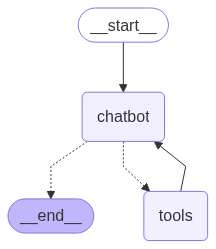

In [33]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
config = {"configurable": {"thread_id": "5"}}

In [24]:
from langchain.schema import AIMessage

def stream_graph_updates(user_input: str):
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config=config,
        stream_mode="values",
    ):
        msg = event['messages'][-1]

        if isinstance(msg, AIMessage):
            print("Assistant: "+msg.content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  who is my name?


Assistant: Your name is Fadly. If you have any other questions or need assistance, feel free to ask!


User:  q


Goodbye!


### Inspect State Thread

In [25]:
snapshot = graph.get_state(config)

In [26]:
snapshot.next

()